# Bike Sharing Demand (Kaggle)
* 시계열 분석을 통해 자전거 수요 예측
* [Bike Sharing Demand (Kaggle)](https://www.kaggle.com/c/bike-sharing-demand/data)

In [1]:
# 라이브러리 호출

import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm  

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings( 'ignore' )

### 1. 데이터 준비

In [2]:
# 데이터 로드
train = pd.DataFrame(pd.read_csv('~/data/data/bike-sharing-demand/train.csv'))
df = train.copy()
# df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**A. datetime 컬럼 전처리**
* year, month, date, hour 단위로 추가 구분

In [3]:
df['year'] = df['datetime'].apply(lambda i: i[0:4])
df['month'] = df['datetime'].apply(lambda i: i[0:7])
df['date'] = df['datetime'].apply(lambda i: i[8:10])
df['hour'] = df['datetime'].apply(lambda i: i[11:13])
df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda i: i[0:10]))
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,date,hour
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,2011-01,01,00
1,2011-01-01,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,2011-01,01,01
2,2011-01-01,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2011-01,01,02
3,2011-01-01,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,2011-01,01,03
4,2011-01-01,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,2011-01,01,04


**B. count 집계 및 시각화**

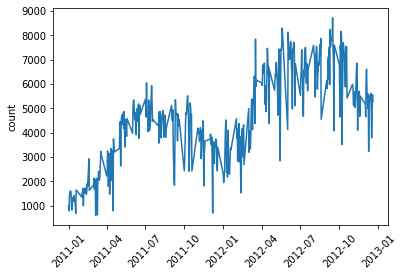

In [27]:
temp = df[(df['year']=='2011')|(df['year']=='2012')]

# 집계
temp = temp.groupby(['datetime']).agg({'season':'mean', 'holiday':'mean', 'workingday':'mean', 'weather':'mean', 'temp':'mean', 'atemp':'mean', 'humidity':'mean', 'windspeed':'mean', 'casual':'mean', 'registered':'mean', 'count':'sum'})

# 시각화
sns.lineplot(data=temp, x='datetime', y='count')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()

**C. 데이터셋 분할**

In [28]:
y = temp['count']
del temp['count']

In [29]:
X_train = temp[:365]
X_test = temp[365:]
y_train = y[:365]
y_test = y[365:]

### 2. SARIMAX
**A. Grid Search**

In [32]:
# 모수
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)

# 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=y_train, exog=X_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 7))
best_param = None
iter_cnt = 0
iter_max = 64

In [33]:
# product 수행
param_combinations = list(product(p,d,q,P,D,Q))

# for 문으로 최소 AIC 찾기 (Grid Search)
for param in param_combinations:
    iter_cnt += 1
    try:
        model=sm.tsa.SARIMAX(endog=y_train,
                             exog=X_train,
                             order=param[:3],
                             seasonal_order=param[3:]+(7,))
        model_fit = model.fit(disp=False) # 로그 메시지 출력 생략
        
        print(f'Iter {iter_cnt}/{iter_max}: SARIMAX{param[:3]}x{param[3:]}(7), AIC = {model_fit.aic}')

        # 현재 파라미터의 AIC가 이전 최적 AIC보다 낮으면 업데이트
        if model_fit.aic < best_AIC:
            best_model_fit = model_fit
            best_param = param
            best_AIC = model_fit.aic
            
    except: 
        continue

Iter 1/64: SARIMAX(0, 0, 0)x(0, 0, 0)(7), AIC = 3878.435315223758
Iter 2/64: SARIMAX(0, 0, 0)x(0, 0, 1)(7), AIC = 3879.88696145878
Iter 3/64: SARIMAX(0, 0, 0)x(0, 1, 0)(7), AIC = 4040.782541182848
Iter 4/64: SARIMAX(0, 0, 0)x(0, 1, 1)(7), AIC = 3832.0645797763054
Iter 5/64: SARIMAX(0, 0, 0)x(1, 0, 0)(7), AIC = 3879.8594675743034
Iter 6/64: SARIMAX(0, 0, 0)x(1, 0, 1)(7), AIC = 3881.8026723302155
Iter 7/64: SARIMAX(0, 0, 0)x(1, 1, 0)(7), AIC = 3945.2467553559027
Iter 8/64: SARIMAX(0, 0, 0)x(1, 1, 1)(7), AIC = 3833.6674122642216
Iter 9/64: SARIMAX(0, 0, 1)x(0, 0, 0)(7), AIC = 3880.3484471947186
Iter 10/64: SARIMAX(0, 0, 1)x(0, 0, 1)(7), AIC = 3881.787212442605
Iter 11/64: SARIMAX(0, 0, 1)x(0, 1, 0)(7), AIC = 4042.6456986650674
Iter 12/64: SARIMAX(0, 0, 1)x(0, 1, 1)(7), AIC = 3834.112992166685
Iter 13/64: SARIMAX(0, 0, 1)x(1, 0, 0)(7), AIC = 3881.763357808453
Iter 14/64: SARIMAX(0, 0, 1)x(1, 0, 1)(7), AIC = 3883.702904378976
Iter 15/64: SARIMAX(0, 0, 1)x(1, 1, 0)(7), AIC = 3947.43861703609

In [34]:
# 최적의 파라미터 및 AIC
print(f'best model: SARIMAX{best_param[:3]}x{best_param[3:]}(7)')
print(f'AIC: {best_AIC}')

best model: SARIMAX(0, 0, 0)x(0, 1, 1)(7)
AIC: 3832.0645797763054


**B. 모델 구조 확인**

In [35]:
print(best_model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:                     count   No. Observations:                  365
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood               -1904.032
Date:                   Sun, 17 Dec 2023   AIC                           3832.065
Time:                           04:55:12   BIC                           3878.631
Sample:                                0   HQIC                          3850.584
                                   - 365                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season         6.9937      5.429      1.288      0.198      -3.647      17.634
holiday      -17.9259     30.040     -0.597      0.551     -76.804      40.952
workingday   -35.3474     11

* Prob(Q): 0.93 > 0.05, 자기상관성 없음
* Prob(JB): 0.00 < 0.05, **정규분포 따르지 않음**
* Prob(H): 0.00 < 0.05, **등분산성 만족하지 않음**

모델 성능은 그다지 좋지 않음

**C. 수요 예측**

In [36]:
exogs = best_model_fit.model.exog[-50:]                      # 외생 변수 저장(마지막 50개)
forecast = best_model_fit.get_forecast(steps=50, exog=exogs) # steps=50
forecast_mean = forecast.predicted_mean                      # 예측값의 평균
conf_int = forecast.conf_int()                               # 신뢰구간

In [60]:
# RMSE 계산
sarimax_rmse = (mean_squared_error(y_test[:50], forecast_mean))
print(f'RMSE: {sarimax_rmse}')

RMSE: 2715499.0471977014


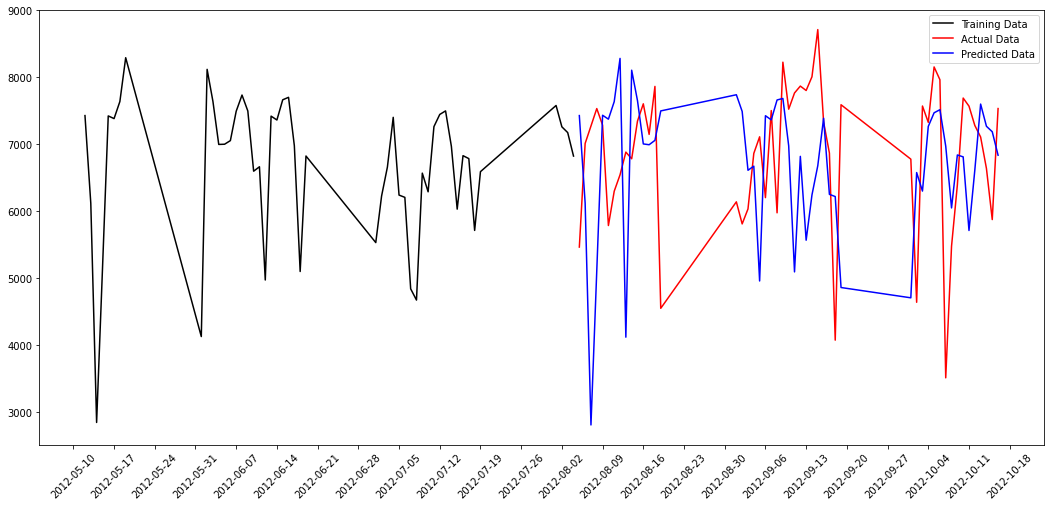

In [59]:
# 예측값 시각화

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))

plt.plot(y_train[-50:].index, y_train[-50:].values, color='k', label='Training Data') # training data
plt.plot(y_test[:50].index, y_test[:50].values, color='r', label='Actual Data')       # actual data
plt.plot(y_test[:50].index, forecast_mean.values, color='b', label='Predicted Data')  # predicted data

# 눈금 간격 조정
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.legend()
plt.show()

### 3. 다른 모델 활용
**A. LGBM**

In [58]:
import lightgbm as lgb

model_lgbm = lgb.LGBMRegressor() # 모델 생성
model_lgbm_fit = model_lgbm.fit(X_train, y_train) # 학습
predictions_lgbm = model_lgbm.predict(X_test) # 예측

In [61]:
# RMSE 계산
lgbm_rmse = (mean_squared_error(y_test, predictions_lgbm))
print(f'RMSE: {lgbm_rmse}')

RMSE: 157549.47689683284


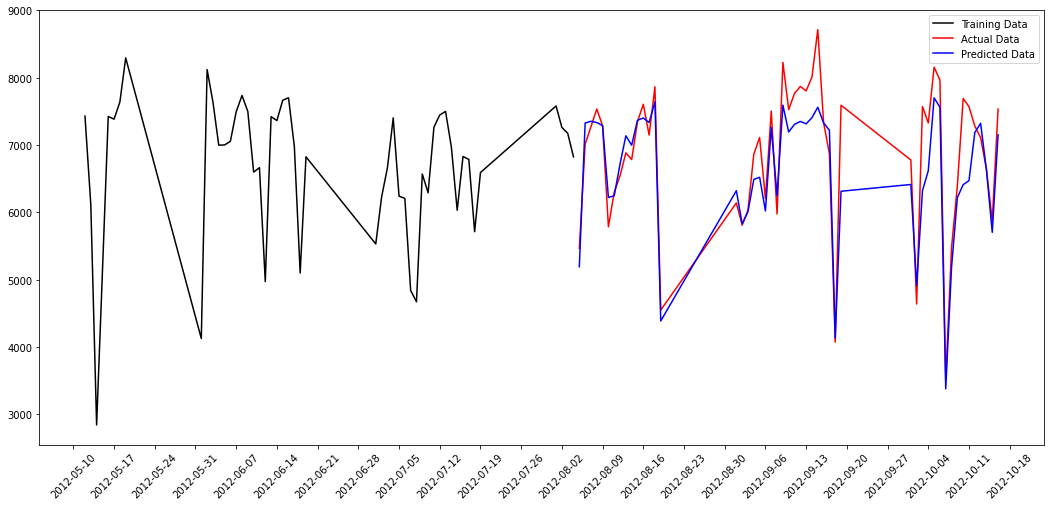

In [46]:
# 시각화

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

plt.plot(y_train[-50:].index, y_train[-50:], color='k', label='Training Data')        # training data
plt.plot(y_test[:50].index, y_test[:50], color='r', label='Actual Data')              # actual data

# 오류 발생
plt.plot(y_test[:50].index, predictions_lgbm[:50], color='b', label='Predicted Data') # predicted data

# 눈금 간격 조정
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.legend()
plt.show()

**XGBoost**

In [49]:
import xgboost as xgb

# 모델 생성
model_xgb = xgb.XGBRegressor(
    objective ='reg:squarederror',
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 5,
    alpha = 10,
    n_estimators = 100
)

model_xgb_fit = model_xgb.fit(X_train, y_train) # 학습
predictions_xgb = model_xgb_fit.predict(X_test) # 예측

In [62]:
# RMSE 계산
xgb_rmse = (mean_squared_error(y_test, predictions_xgb))
print(f'RMSE: {xgb_rmse}')

RMSE: 723006.4974694626


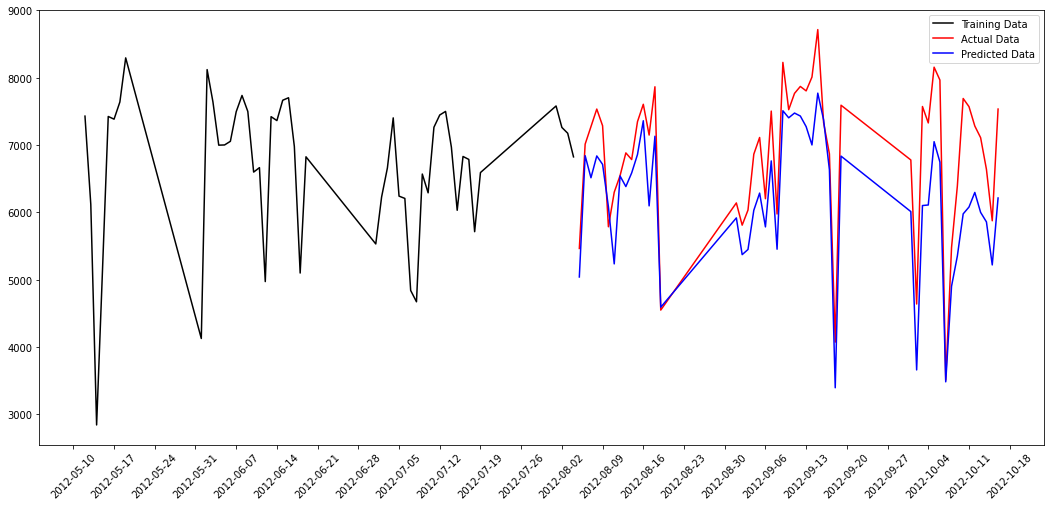

In [51]:
# 시각화

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

plt.plot(y_train[-50:].index, y_train[-50:], color='k', label='Training Data')       # training data
plt.plot(y_test[:50].index, y_test[:50], color='r', label='Actual Data')             # actual data
plt.plot(y_test[:50].index, predictions_xgb[:50], color='b', label='Predicted Data') # predicted data

# 눈금 간격 조정
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.legend()
plt.show()

**C. Random Forest**

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
model_rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=25)
model_rf_fit = model_rf.fit(X_train, y_train) # 학습
predictions_rf = model_rf_fit.predict(X_test) # 예측

In [63]:
# RMSE 계산
rf_rmse = (mean_squared_error(y_test, predictions_rf))
print(f'RMSE: {rf_rmse}')

RMSE: 141644.61252967032


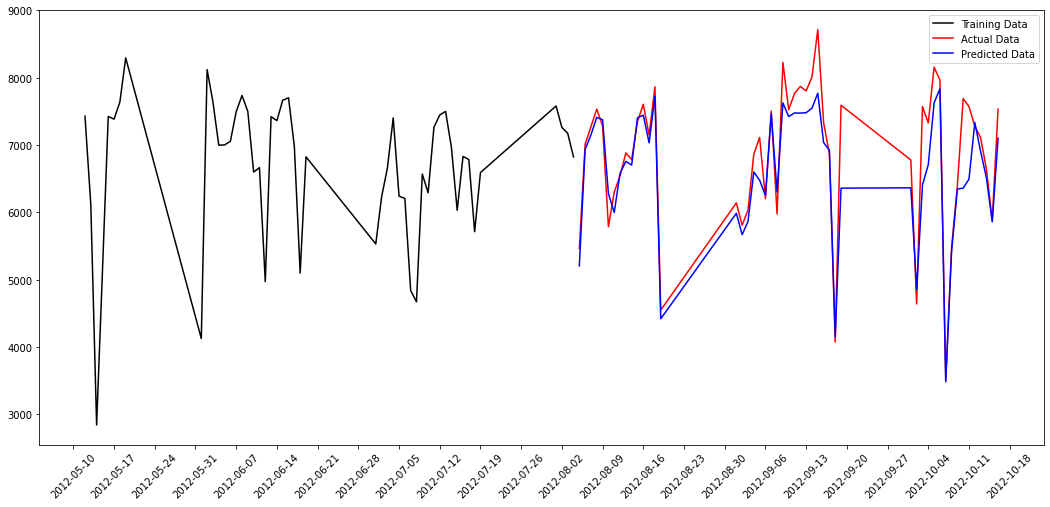

In [64]:
# 시각화

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

plt.plot(y_train[-50:].index, y_train[-50:], color='k', label='Training Data')   # training data
plt.plot(y_test[:50].index, y_test[:50], color='r', label='Actual Data')         # actual data
plt.plot(y_test[:50].index, predictions_rf[:50], color='b', label='Predicted Data') # predicted data

# 눈금 간격 조정
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.legend()
plt.show()

### 4. 결과 비교
**A. RMSE**

In [79]:
rmse_df = pd.DataFrame({
    'Model':['SARIMAX', 'LGBM', 'XGB', 'Random Forest'],
    'RMSE':[sarimax_rmse, lgbm_rmse, xgb_rmse, rf_rmse]
})
rmse_df.sort_values(by='RMSE')

,Model,RMSE
3,Random Forest,1.416446e+05
1,LGBM,1.575495e+05
2,XGB,7.230065e+05
0,SARIMAX,2.715499e+06


**B. 시각화**

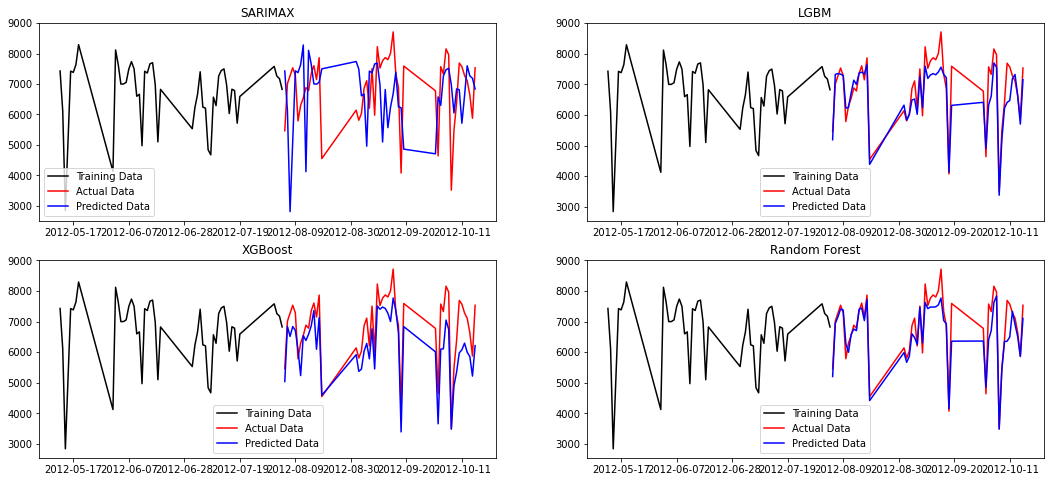

In [80]:
# 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

# SARIMAX
ax1.plot(y_train[-50:].index, y_train[-50:].values, color='k', label='Training Data')
ax1.plot(y_test[:50].index, y_test[:50].values, color='r', label='Actual Data')
ax1.plot(y_test[:50].index, forecast_mean.values, color='b', label='Predicted Data')

# LGBM
ax2.plot(y_train[-50:].index, y_train[-50:], color='k', label='Training Data')
ax2.plot(y_test[:50].index, y_test[:50], color='r', label='Actual Data')
ax2.plot(y_test[:50].index, predictions_lgbm[:50], color='b', label='Predicted Data')

# XGBoost
ax3.plot(y_train[-50:].index, y_train[-50:], color='k', label='Training Data')
ax3.plot(y_test[:50].index, y_test[:50], color='r', label='Actual Data')
ax3.plot(y_test[:50].index, predictions_xgb[:50], color='b', label='Predicted Data')

# Random Forest
ax4.plot(y_train[-50:].index, y_train[-50:], color='k', label='Training Data')
ax4.plot(y_test[:50].index, y_test[:50], color='r', label='Actual Data')
ax4.plot(y_test[:50].index, predictions_rf[:50], color='b', label='Predicted Data')

# 눈금 간격 조정
loc = plticker.MultipleLocator(base=21.0) 
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)
ax3.xaxis.set_major_locator(loc)
ax4.xaxis.set_major_locator(loc)

# Title
ax1.set_title('SARIMAX')
ax2.set_title('LGBM')
ax3.set_title('XGBoost')
ax4.set_title('Random Forest')

# Legend
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.show()

* Random Forest, LGBM 모델의 RMSE 값이 낮게 측정됨
* 그래프로 확인해 봐도 두 모델의 정확도가 다른 모델에 비해 우수한 걸 확인할 수 있음

### 5. 결론
* SRIMAX를 비롯하여 다양한 회귀 모델을 활용해 수요를 예측해 봄
* RMSE 값이 우수한 Random Forest, LGBM 모델에 대해 성능 개선을 시도해 보면 좋을 것 같음
* 결측 데이터에 대한 아쉬움이 남음